In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Main Code

In [ ]:
from focalloss import FocalLoss

In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets

import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as af
import os
import numpy as np
import pandas as pd
import cv2
from torch.utils.data import Dataset
import PIL
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.manifold import TSNE
from google.colab import files


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/MNIST_dl/test.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/MNIST_Data')

with zipfile.ZipFile('/content/drive/MyDrive/MNIST_dl/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/MNIST_Data')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([transforms.Grayscale(), 
                                         transforms.ToTensor(),
                                         transforms.Resize((28,28)), 
                                         transforms.Normalize(0,0.5)])

**Loading Data:**

In [ ]:
train_imgs_path = "/content/MNIST_Data/train_new"
train_labels_path = "/content/MNIST_Data/train.csv"


test_imgs_path = "/content/MNIST_Data/test_new"
test_labels_path = "/content/MNIST_Data/test.csv"


**Creating Directories For Each Class**

In [ ]:
def create_directories(root_dir, dirs_name):
  os.makedirs(root_dir,exist_ok = True)
  for d_name in dirs_name:
    os.makedirs(os.path.join(root_dir,str(d_name)),exist_ok=True)

create_directories('train',np.arange(0,10))
create_directories('test',np.arange(0,10))

Put data into directories

In [ ]:
df_train = pd.read_csv("/content/MNIST_Data/train.csv")
df_test = pd.read_csv("/content/MNIST_Data/test.csv")

In [ ]:
l = df_train['Label'].to_numpy()
label,count = np.unique(l,return_counts=True)
print(np.vstack((label,count)))

[[   0    1    2    3    4    5    6    7    8    9]
 [ 500 6742 5958 6131  500 5421 5918  500 5851 5949]]


In [ ]:
missing = list()
names = list()

def read_imgs_create_dir(r_path,w_path,imgs_names,label):

  for img in imgs_names:

    image  = cv2.imread(os.path.join(r_path,str(img)))
    if image is not None:
      cv2.imwrite(os.path.join(w_path,label,str(img)),image)
    else:
      names.append(str(img))
      missing.append(label)


def put_imgs_to_dir(dir_path_r,dir_name_w, imgs_name_labels,num_classes):
  """
  imgs_name_labels:
    - it is a data frame object with two columns containing images names and labels. 

  """

  # labels = imgs_name_labels.to_numpy()
  for label in num_classes:
    img_id = imgs_name_labels.loc[imgs_name_labels['Label']==label]
    read_imgs_create_dir(dir_path_r,dir_name_w,img_id['FileName'].to_numpy(),str(label))


put_imgs_to_dir(train_imgs_path,'train',df_train,np.arange(0,10))
put_imgs_to_dir(test_imgs_path,'test',df_test,np.arange(0,10))


In [ ]:
class Custom_Dataset(Dataset):
  def __init__(self, csv_file, img_dir, transform=None): 
    # Run once
    self.img_labels = pd.read_csv(csv_file)
    self.transform = transform
    self.img_dir = img_dir
    

  def __len__(self):
    # return the number of samples in dataset
    return len(self.img_labels)

  def __getitem__(self, idx):
    # loads and returns a sample from the dataset at the given index
    img_path = os.path.join(self.img_dir ,str(self.img_labels.iloc[idx, 1]),self.img_labels.iloc[idx, 0])
    # print(img_path)
    image = PIL.Image.open(img_path)
    label = torch.tensor(self.img_labels.iloc[idx, 1])
    
    if self.transform:
      image = self.transform(image)
        
    return image, label

In [ ]:
train_data = Custom_Dataset(csv_file=train_labels_path, img_dir='train', transform=transform)

# creating dataset iterator
train_per = 0.8
train_size = int(len(train_data)*train_per)
val_size = int(np.ceil(len(train_data)*(1-train_per)))
(train_data,val_data) = torch.utils.data.random_split(train_data,[train_size,val_size])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

test_data = Custom_Dataset(csv_file=test_labels_path, img_dir='test', transform=transform)

# creating dataset iterator
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
class FCNetwork(nn.Module):
    def __init__(self,input_dim, output_dim, hidden_layers) -> None:
      super(FCNetwork,self).__init__()
      self.fc1 = nn.Linear(input_dim,hidden_layers[0])
      self.fc2 = nn.Linear(hidden_layers[0],hidden_layers[1])
      self.fc3 = nn.Linear(hidden_layers[1],hidden_layers[2])
      self.fc4 = nn.Linear(hidden_layers[2],hidden_layers[3])

    def forward(self, x):
      x = torch.flatten(x,1)
      x = af.relu(self.fc1(x))
      x = af.relu(self.fc2(x))
      x = af.relu(self.fc3(x))
      x = self.fc4(x)
      return x

    def save_model(self, path):
      torch.save(self.state_dict(),path)

    def load_model(self, path):
      self.load_state_dict(torch.load(path))


    def test(self, test_loader,loss_func,batch_size):
      loader=tqdm(test_loader)
      ep_acc = 0
      accuracy = 0
      ep_loss = 0
      loss = 0
      n_dp=0
      for batch, (imgs,labels) in enumerate(loader):

        imgs=imgs.to(device=device)
        labels=labels.to(device=device)

        pred = self.forward(imgs)
        ep_loss = loss_func(pred,labels)
        ep_acc = (pred.argmax(1)==labels).type(torch.float).sum().item()
        n_dp+=labels.size(0)
        accuracy+=ep_acc
        loss+=ep_loss

      print(f"Accuracy: {accuracy/n_dp}, Loss: {loss/n_dp}")

      return {accuracy/len(test_loader)}, loss/len(test_loader)

    def check_accuracy(self, loader):
      num_correct = 0
      num_samples = 0
      # self.eval()

      with torch.no_grad():
          for x, y in loader:
              x = x.to(device=device)
              y = y.to(device=device)
              # x = x.reshape(x.shape[0], -1)

              scores = self.forward(x)
              _, predictions = scores.max(1)
              num_correct += (predictions == y).sum()
              num_samples += predictions.size(0)

      # self.train()
      print(num_correct/num_samples)

      return num_correct/num_samples

    def visualize_predictions(self, data):
      """
      data: 
        - DataLoader class's object with batch size = 1
      """
      for i in range(8):
        data_iter = iter(data)
        img, label = data_iter.next()

        pred = self.forward(img)
        
        predicted_label_index = pred.argmax(1)

        gt_img = img.numpy().squeeze(axis=(0,1))
        # cv2.putText(gt_img,f"GT: {label.item()}, Pred: {predicted_label_index}",org=(2,25),fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        #             fontScale=0.03,color=255,thickness=1)

        plt.imshow(gt_img)
        plt.show()
        print(f"GT: {label.item()}, Pred: {predicted_label_index.item()}")
      

    def train(self, train_loader,val_loader,learning_rate, training_epochs, loss_func,optimizer, early_stopping_epochs=7):#train_set_x, train_set_y, valid_set_x,valid_set_y,


      train_loss = list()
      train_accuracy = list()
      val_loss = list()
      val_accuracy = list()
      train_loss_batch = 0
      val_loss_batch = 0
      weight_after_first_pass = None
      weight_after_last_pass = None
      t_loss_min = 0
      epochs_no_change_es = 0
      for epoch in range(training_epochs):
        train_loss_batch = 0
        val_loss_batch = 0
        epoch_acc = 0

        loader = tqdm(train_loader)
        for batch_idx,(img,labels) in enumerate(loader):
          img = img.to(device=device)
          labels = labels.to(device=device)

          data = img.reshape(img.shape[0],-1)
          pred = self.forward(data)
          loss = loss_func(pred,labels)
          train_loss_batch += loss.item()
          acc = (pred.argmax(1) == labels).type(torch.float).sum().item()/labels.size(0)
          epoch_acc +=acc
          # acc += check_accuracy(train_loader,net)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, training_epochs, batch_idx+1, len(train_loader), loss.item()))
          loader.set_description(f"Training, Epoch[{epoch+1}/{training_epochs}], Step[{batch_idx+1}/{len(train_loader)}]")
          loader.set_postfix(loss=loss.item(),acc=acc)
        
        t_loss = train_loss_batch/64
        train_loss.append(t_loss)
        train_accuracy.append(epoch_acc/64)

        epoch_acc = 0
        v_loss_min = 0
        loader = tqdm(val_loader)
        for batch_idx,(img,labels) in enumerate(loader):
          img = img.to(device=device)
          labels = labels.to(device=device)

          data = img.reshape(img.shape[0],-1)
          pred = self.forward(data)
          loss = loss_func(pred,labels)
          val_loss_batch += loss.item()
          acc = (pred.argmax(1) == labels).type(torch.float).sum().item()/labels.size(0)

          epoch_acc+=acc
          loader.set_description(f"Validation, Epoch[{epoch+1}/{training_epochs}], Step[{batch_idx+1}/{len(val_loader)}]")
          loader.set_postfix(loss=loss.item(),acc=acc)

        v_loss = val_loss_batch/64
        val_loss.append(v_loss)
        val_accuracy.append(epoch_acc/64)

        if v_loss < v_loss_min:
          v_loss_min = v_loss
          epochs_no_change_es = 0

        elif t_loss > t_loss_min or round(t_loss,1) == round(t_loss_min,1):
          epochs_no_change_es += 1

        if early_stopping_epochs > epochs_no_change_es:
          continue
        else:
          early_stopping = True
        
        if early_stopping:
          return self, train_loss, val_loss, train_accuracy, val_accuracy


      return net, train_loss, val_loss, train_accuracy, val_accuracy




In [ ]:
trainloss=list()
valloss=list()
trainacc=list()
valacc=list()
W1=list()
W2=list()

In [ ]:
#https://github.com/ashawkey/FocalLoss.pytorch/blob/master/focalloss.py 
# focal loss


# fl, sgd
net = FCNetwork(28*28,10,[64,128,256,10]).to(device)
learning_rate = 0.001
# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss()
optimizer = opt.Adam(net.parameters(), lr=learning_rate)
# optimizer = opt.SGD(net.parameters(), lr=learning_rate,momentum=0.7)

net, train_loss, val_loss, train_accuracy, val_accuracy,w1,w2 = net.train(train_loader,val_loader,
                                                                learning_rate=learning_rate,training_epochs=15,loss_func=criterion,optimizer=optimizer)

# net.save_model("fcnn,fl,adams.pt")
# files.download("fcnn,fl,adams.pt")

# trainloss.append(train_loss)
# valloss.append(val_loss)

# trainacc.append(train_accuracy)
# valacc.append(val_accuracy)

# W1.append(w1)
# W2.append(w2)


# # FL, Adams
# net = FCNetwork(28*28,10,[64,128,256,10]).to(device)
# learning_rate = 0.001
# # criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss()
# # optimizer = opt.Adam(net.parameters(), lr=learning_rate)
# optimizer = opt.SGD(net.parameters(), lr=learning_rate,momentum=0.7)

# net, train_loss, val_loss, train_accuracy, val_accuracy,w1,w2 = net.train(train_loader,val_loader,
#                                                                 learning_rate=learning_rate,training_epochs=15,loss_func=criterion,optimizer=optimizer)

# net.save_model("fcnn,fl,sgd.pt")
# files.download("fcnn,fl,sgd.pt")

# trainloss.append(train_loss)
# valloss.append(val_loss)

# trainacc.append(train_accuracy)
# valacc.append(val_accuracy)

# W1.append(w1)
# W2.append(w2)


# #CE_SGD
# net = FCNetwork(28*28,10,[64,128,256,10]).to(device)
# learning_rate = 0.001
# criterion = nn.CrossEntropyLoss()
# # criterion = FocalLoss()
# # optimizer = opt.Adam(net.parameters(), lr=learning_rate)
# optimizer = opt.SGD(net.parameters(), lr=learning_rate,momentum=0.7)

# net, train_loss, val_loss, train_accuracy, val_accuracy,w1,w2 = net.train(train_loader,val_loader,
#                                                                 learning_rate=learning_rate,training_epochs=15,loss_func=criterion,optimizer=optimizer)

# net.save_model("fcnn,ce,sgd.pt")
# files.download("fcnn,ce,sgd.pt")

# trainloss.append(train_loss)
# valloss.append(val_loss)

# trainacc.append(train_accuracy)
# valacc.append(val_accuracy)

# W1.append(w1)
# W2.append(w2)


# # CE_adams


# net = FCNetwork(28*28,10,[64,128,256,10]).to(device)
# learning_rate = 0.001
# criterion = nn.CrossEntropyLoss()
# # criterion = FocalLoss()
# optimizer = opt.Adam(net.parameters(), lr=learning_rate)
# # optimizer = opt.SGD(net.parameters(), lr=learning_rate,momentum=0.7)

# net, train_loss, val_loss, train_accuracy, val_accuracy,w1,w2 = net.train(train_loader,val_loader,
#                                                                 learning_rate=learning_rate,training_epochs=15,loss_func=criterion,optimizer=optimizer)

# net.save_model("fcnn,ce,adams.pt")
# files.download("fcnn,ce,adams.pt")

# trainloss.append(train_loss)
# valloss.append(val_loss)

# trainacc.append(train_accuracy)
# valacc.append(val_accuracy)

# W1.append(w1)
# W2.append(w2)




# import pickle as pk


# tl = "train_l.pkl"
# vl = "val_l.pkl"

# va="val_acc.pkl"
# ta="train_acc.pkl"

# with open(tl,'wb') as f:
#   pk.dump(train_loss,f)

# with open(vl,'wb') as f:
#   pk.dump(val_loss,f)

# with open(ta,'wb') as f:
#   pk.dump(train_accuracy,f)


# with open(va,'wb') as f:
#   pk.dump(val_accuracy,f)


# files.download(tl)
# files.download(vl)
# files.download(ta)
# files.download(va)


Validation, Epoch[7/15], Step[136/136]: 100%|██████████| 136/136 [00:07<00:00, 17.84it/s, acc=0.963, loss=0.0696]


ValueError: ignored

In [ ]:
acc1 = net.check_accuracy(test_loader)


tensor(0.8341)


In [ ]:
num_correct = 0
num_samples = 0
with torch.no_grad():
  for b,(x,y) in enumerate(test_loader):

    x = x.to(device=device)
    y = y.to(device=device)
    # x = x.reshape(x.shape[0], -1)

    scores = net.forward(x)
    _, predictions = scores.max(1)
    num_correct += (predictions == y).sum()
    num_samples += predictions.size(0)

        # self.train()
  print(num_samples)
  print(num_correct/num_samples)

10000
tensor(0.8341)


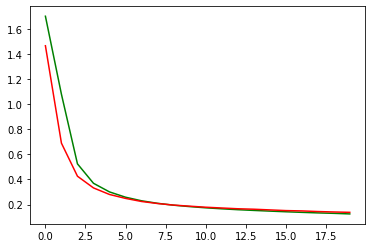

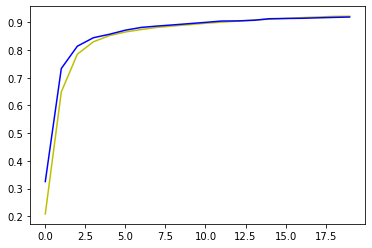

In [ ]:
from matplotlib import pyplot as plt

plt.plot(np.array(train_loss),'g')
plt.plot(np.array(val_loss),'r')

plt.show()

plt.plot(np.array(train_accuracy),'y')
plt.plot(np.array(val_accuracy),'b')
plt.show()

In [ ]:
train_data = Custom_Dataset(csv_file=train_labels_path, img_dir='train', transform=transform)

# creating dataset iterator
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)

label = list()
gt = list()

for batch, (imgs,labels) in enumerate(train_loader):

  imgs = imgs.to(device=device)
  labels = labels.to(device=device)

  pred = net.forward(imgs)
  pred_label = pred.argmax(1).cpu().numpy()[0]
  t = pred.amax(axis=1)
  actual_label = labels.item()


  label.append(pred_label)
  gt.append(actual_label)



In [ ]:
print(gt[:10])

[3, 5, 5, 3, 9, 8, 8, 3, 8, 2]


In [ ]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(gt, label, pos_label=9)

In [ ]:
print(" does not take label imbalance into account.MACRO", metrics.f1_score(gt, label, average='macro'))
print("Class imbalanced into account", metrics.f1_score(gt, label, average='weighted'))

 does not take label imbalance into account.MACRO 0.7686389849652622
Class imbalanced into account 0.897152256130144


In [ ]:
from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(gt,label)

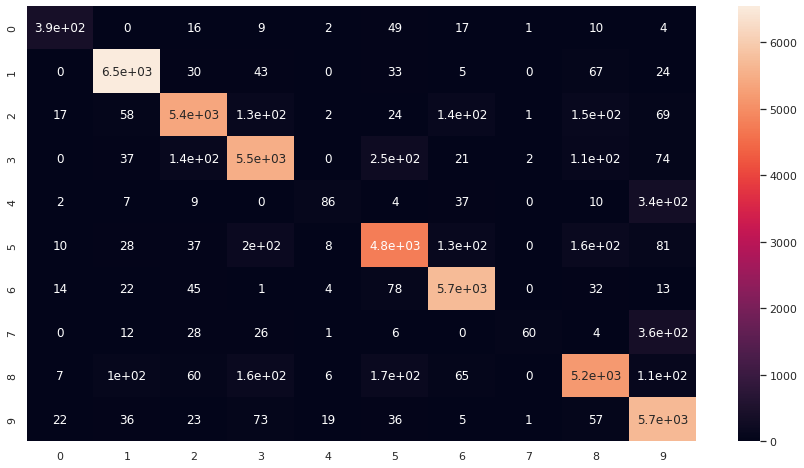

In [ ]:
from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(gt,label)
import seaborn as snNew


DetaFrame_cm = pd.DataFrame(cm_train, range(10), range(10))
snNew.heatmap(DetaFrame_cm, annot=True)
snNew.set(rc = {'figure.figsize':(20,20)})

plt.show()

In [ ]:
metrics.accuracy_score(gt, label, normalize=True)

0.9034046468829078

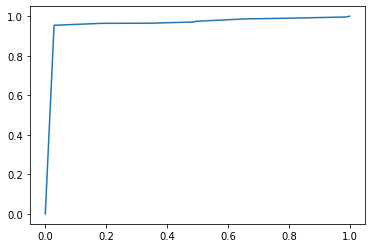

In [ ]:
plt.plot(fpr,tpr)
plt.show()

TSNe

In [ ]:
def check_accuracy(loader, model,val_loader,learning_rate=0.001, epochs=5,optimizer=optimizer,loss_func=criterion):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct/num_samples


print(f"Accuracy on training set: {check_accuracy(train_loader, net,val_loader, learning_rate, epochs=0.001, loss_func=criterion, optimizer=optimizer)*100:.2f}")
# print(f"Accuracy on test set: {check_accuracy(test_loader, net)*100:.2f}")